### Dynamics functions ###

In [25]:
"""
    generate_initial_conditions(N::Int, L::Int)

Generate the initial conditions of a system with `N` agents and `L` labels.

Returns:
- `L_i`: Array with the label of each agent
- `N_i`: Array with the number of agents in each label at two times
- `p_i`: Array with the momentum of each label
"""
function generate_initial_conditions(N::Int, L::Int)
    L_i = fill(0, N) 
    N_i = [fill(0, L), fill(0, L)] 
    p_i = fill(0, L) 

    # Assigning a random label for each agent (We suppose that the previous label is also random)
    for i in 1:N
        N_i[1][rand(1:L)] += 1
        L_i[i] = rand(1:L)
        N_i[2][L_i[i]] += 1
    end

    # Calculating the momentum of each label
    for i in 1:L
        p_i[i] = N_i[2][i] - N_i[1][i]
    end
    N_i[1] .= N_i[2]

    return L_i, N_i, p_i
end

"""
    interaction(i::Int, j::Int, N_i::Vector{Vector{Int}}, L_i::Vector{Int}, p_i::Vector{Int}, N::Int, β::Float64)

Define interaction between agents `i` and `j` in the system.
"""
function interaction(i::Int, j::Int, N_i::Vector{Vector{Int}}, L_i::Vector{Int}, p_i::Vector{Int}, N::Int, β::Float64)
    q = 1 / (1 + exp(-β * (p_i[L_i[j]] - p_i[L_i[i]]) / (2 * N)))
    if rand() <= q
        N_i[2][L_i[i]] -= 1
        N_i[2][L_i[j]] += 1
        L_i[i] = L_i[j]
    end
end

"""
    measures(N_i::Vector{Vector{Int}}, p_i::Vector{Int}, N::Int, L::Int)

Calculate various measures of the system.

Returns:
- `S`: Entropy
- `Pc/N`: Maximum proportion of agents in any label
- `Sc/N^2`: Sum of squares of proportions of agents in labels
"""
function measures(N_i::Vector{Vector{Int}}, p_i::Vector{Int}, N::Int, L::Int)
    Pc = maximum(N_i[2])
    Sc = 0.0
    S = 0.0
    for i in 1:L
        p_i[i] = N_i[2][i] - N_i[1][i]
        if N_i[2][i] > 0
            S += -(N_i[2][i] / N) * log(N_i[2][i] / N)
        end
        Sc += N_i[2][i]^2
    end
    Sc += -Pc^2
    N_i[1] .= N_i[2]
    return S, (Pc / N), (Sc / N^2)
end

"""
    find_n_greatest(arr, n)

Find the first 'n' greatest values of a given array 'arr' and returns an array with them in decrescent order.

"""

function find_n_greatest(arr, n)
    # Create a copy of the array to avoid modifying the original
    arr_copy = copy(arr)
    greatest_values = []

    for i in 1:n
        max_value = maximum(arr_copy)
        push!(greatest_values, max_value)
        # Remove the maximum value found
        deleteat!(arr_copy, findfirst(==(max_value), arr_copy))
    end

    return greatest_values
end

"""
    generate_arrays(N, L, β, ensembles, n_greatest)

Set up the arrays that will store the data during the simulation.

"""
function generate_arrays(N, L, β, ensembles, n_greatest)
    iteration = []
    entropy = []
    percolation = []
    suscept = []
    τ = []
    labels_evolution = []
    
    for n in eachindex(N)
        push!(iteration, [])
        push!(entropy, [])
        push!(percolation, [])
        push!(suscept, [])
        push!(τ, [])
        push!(labels_evolution, [])
        for l in eachindex(L)
            push!(iteration[n], [])
            push!(entropy[n], [])
            push!(percolation[n], [])
            push!(suscept[n], [])
            push!(τ[n], [])
            push!(labels_evolution[n], [])

            for b in eachindex(β)
                push!(iteration[n][l], [])
                push!(entropy[n][l], [])
                push!(percolation[n][l], [])
                push!(suscept[n][l], [])
                push!(τ[n][l], [])
                push!(labels_evolution[n][l], [])
                for aux1 in 1:ensembles
                    push!(iteration[n][l][b], [])
                    push!(entropy[n][l][b], [])
                    push!(percolation[n][l][b], [])
                    push!(suscept[n][l][b], [])
                    push!(labels_evolution[n][l][b], [])
                    for i in 1:n_greatest
                        push!(labels_evolution[n][l][b][aux1], [])
                    end
                end
            end
        end
    end

    return iteration, entropy, percolation, suscept, τ, labels_evolution
end

generate_arrays

### Plots functions ###

In [29]:
using Plots
using LaTeXStrings
using DataFrames
using GLM
theme(:default)

"""
    plot_measures(iteration, entropy, percolation, suscept, N, L, β,  n, l, b)

Plot the entropy, percolation and susceptibility given a value of 'n ∈ N', 'l ∈ L' and 'b ∈ β' that has been used in the simulation.

"""
function plot_measures(iteration, entropy, percolation, suscept, N, L, β, ensembles, n, l, b)
    n_index = findfirst(==(n), N)
    l_index = findfirst(==(l), L)
    b_index = findfirst(==(b), β)

    pl = plot(iteration[n_index][l_index][b_index][1:ensembles], entropy[n_index][l_index][b_index][1:ensembles], xlabel="tempo [interações]", ylabel=L"$S$", label=false)
    hline!([log10(l)], line=:dash, linewidth=1, color=:black, label=false)
    plot!(minorgrid=true, title="N=$n, L=$l, β =$b", framestyle=:box, legend=:right )
    ylims!(0, log10(l) + 0.02)
    display(pl)

    pl = plot(iteration[n_index][l_index][b_index][1:ensembles], percolation[n_index][l_index][b_index][1:ensembles], xlabel="tempo [interações]", ylabel=L"$P_c$", label=false)
    hline!([1], line=:dash, linewidth=1, color=:black, label=false)
    plot!(minorgrid=true, framestyle=:box, legend=:right )
    ylims!(0, 1.02)
    display(pl)

    pl = plot(iteration[n_index][l_index][b_index][1:ensembles], suscept[n_index][l_index][b_index][1:ensembles], xlabel="time [iterations]", ylabel=L"$S_c/N^2$", label=false)
    plot!(minorgrid=true, title="N=$n, L=$l, β =$b", framestyle=:box, legend=:right )
    display(pl)
end

"""
    fit_data(x, y)

Receive two arrays and fits the data with a linear regression.

Returns:
- 'slope': Float with the value of the angular coefficient
- 'intercept': Float with the value of the linear coefficient
"""

function fit_data(x, y)
    # Create DataFrame
    data = DataFrame(
        X = x,
        Y  = y
    )
    # Fit the model
    model = lm(@formula(Y ~ X), data)
    # Get the fitted values
    data.Y_pred = predict(model)
    coefficients = coef(model)
    intercept = round(coefficients[1], digits=2)
    slope = round(coefficients[2], digits=2)
    return data, slope, intercept
end

"""
    plot_τ_fixed_l(τ, N, L, β, l)

Make a scatter plot of log(τ) vs log(N) for each β with a fixed value of l ∈ L and fit the data with a linear regression.

"""
function plot_τ_fixed_l(τ, N, L, β, l)
    l_index = findfirst(==(l), L)

    pl = plot(xlabel=L"$log(N)$", ylabel=L"$log(\tau)$", minorgrid=true, framestyle=:box)
    for b in eachindex(β)
        temp_τ = []
        for n in eachindex(N)
            push!(temp_τ, τ[n][l_index][b])
        end
        data, slope, intercept = fit_data(log10.(N), log10.(temp_τ))

        scatter!(data.X, data.Y, label=L"$\beta = %$(β[b])$", color=palette(:default)[b])
        plot!(data.X, data.Y_pred, label=L"$Y = %$intercept + %$slope * X$", line=:dash, color=palette(:default)[b])
    end
    display(pl)
end

"""
    plot_τ_fixed_β(τ, N, L, β, b)

Make a scatter plot of log(τ) vs log(N) for each L with a fixed value of b ∈ β and fit the data with a linear regression.

"""
function plot_τ_fixed_β(τ, N, L, β, b)
    b_index = findfirst(==(b), β)

    pl = plot(xlabel=L"$log(N)$", ylabel=L"$log(\tau)$", minorgrid=true, framestyle=:box)
    for l in eachindex(L)
        temp_τ = []
        for n in eachindex(N)
            push!(temp_τ, τ[n][l][b_index])
        end
        data, slope, intercept = fit_data(log10.(N), log10.(temp_τ))

        scatter!(data.X, data.Y, label=L"$L = %$(L[l])$", color=palette(:default)[l])
        plot!(data.X, data.Y_pred, label=L"$Y = %$intercept + %$slope * X$", line=:dash, color=palette(:default)[l])
    end
    display(pl)
end

"""
    fermi_function(x, β)

Returns the value of the Fermi-Dirac function given a value 'x' and a temperature 'β'.

"""
function fermi_function(x, β)
    return  1 / (1 + exp((-β*x)))
end

"""
    plot_fermi_function(β)

Plot the Fermi-Dirac function for x ∈[-1,1] for a given set of 'β'.

"""
function plot_fermi_function(β)
    x = -1:0.001:1
    pl = plot()
    for j in eachindex(β)
        y = []
        for i in x
            push!(y, fermi_function(i, β[j]))
        end
        plot!(x, y, label="β = $(β[j])")
    end
    plot!(xlabel=L"x", ylabel=L"Probabilidade $q_{ij}$", minorgrid=true, framestyle=:box,)
    ylims!(-0.02, 1.02)
    xlims!(-1,1)
    display(pl)
end

"""
    plot_labels_evolution(iteration, labels_evolution, N, L, β, ensembles, n_greatest, n, l, b)

Plot the evolution of the 'n_greatest' labels of a random ensamble for given a value of 'n ∈ N', 'l ∈ L' and 'b ∈ β' that has been used in the simulation.

"""
function plot_labels_evolution(iteration, labels_evolution, N, L, β, ensembles, n_greatest, n, l, b)
    n_index = findfirst(==(n), N)
    l_index = findfirst(==(l), L)
    b_index = findfirst(==(b), β)

    pl = plot(xlabel="time [iterations]", ylabel=L"$N_i/N$", title="N=$n, L=$l, β =$b", minorgrid=true, framestyle=:box)
    a = rand(1:ensembles)
    for i in 1:n_greatest
        plot!(iteration[n_index][l_index][b_index][a], labels_evolution[n_index][l_index][b_index][a][i], label="$(i)° tendência")
    end
    hline!([1], line=:dash, linewidth=1, color=:black, label=false)
    ylims!(0, 1.02)
    display(pl)
end

function plot_τ_over_N(τ, N, L, β, l)
    l_index = findfirst(==(l), L)

    pl = plot(xlabel=L"$\beta$", ylabel=L"$\tau/N$", title="L=$l", minorgrid=true, framestyle=:box)
    for n in eachindex(N)
        temp_τ = []
        for b in eachindex(β)
            push!(temp_τ, τ[n][l_index][b])
        end
        temp_τ = temp_τ/N[n]

        plot!(β, temp_τ, label=L"$N = %$(N[n])$", color=palette(:default)[n])
    end
    display(pl)
end


plot_τ_over_N (generic function with 1 method)

### Dynamics ###

In [38]:
# Parameters of the simulation
# N := number of agents, L := number of labels, β := temperature
# ensembles := # of ensembles for each configuration, n_greatest := # of the greatest labels to track in each configuration and ensemble
N = [10, 25, 50, 100, 250, 500, 750, 1000, 2000]
L = [10^1]
β = [1/100, 1/10, 1.0, 5.0, 1e1, 1e2, 1e3]
ensembles = 100
n_greatest = 0

# Arrays with the measures
iteration, entropy, percolation, suscept, τ, labels_evolution = generate_arrays(N, L, β, ensembles, n_greatest)

# Passes through the values of N
for n in eachindex(N)
    # Passes through the values of L
    for l in eachindex(L)
        # Passes through the values of β
        for b in eachindex(β)
            fixation_time = 0
            for aux1 in 1:ensembles
                L_i, N_i, p_i = generate_initial_conditions(N[n], L[l])

                t = 0
                # The dynamics will occur until one label is fully occupied
                while maximum(N_i[2] / N[n]) != 1
                    # Makes the interaction of two random agents N times
                    for aux2 in 1:N[n]
                        i = rand(1:N[n])
                        j = rand(1:N[n])
                        interaction(i, j, N_i, L_i, p_i, N[n], β[b])
                    end

                    # Makes some relevant measures
                    S, Pc, Sc = measures(N_i, p_i, N[n], L[l])
                    push!(iteration[n][l][b][aux1], t)
                    push!(entropy[n][l][b][aux1], S)
                    push!(percolation[n][l][b][aux1], Pc)
                    push!(suscept[n][l][b][aux1], Sc)

                    #greatest_values = find_n_greatest(N_i[2]/N[n], n_greatest)
                    #for i in 1:n_greatest
                    #    push!(labels_evolution[n][l][b][aux1][i], greatest_values[i])
                    #end

                    t += 1
                end
                fixation_time += t
            end
            τ[n][l][b] = fixation_time / ensembles
        end
    end
end

### Plots ###

In [48]:
function plot_τ_over_N(τ, N, L, β, l)
    l_index = findfirst(==(l), L)

    pl = plot(xlabel=L"$\beta$", ylabel=L"$\tau/N$", title="L=$l", minorgrid=true, framestyle=:box)
    for n in eachindex(N)
        temp_τ = []
        for b in eachindex(β)
            push!(temp_τ, τ[n][l_index][b])
        end
        temp_τ = temp_τ/N[n]

        plot!(β, temp_τ, label=L"$N = %$(N[n])$", color=palette(:default)[n])
    end
    xlims!(0,25)
    display(pl)
end

plot_τ_over_N (generic function with 1 method)

In [43]:
function plot_τ_over_N2(τ, N, L, β, l)
    l_index = findfirst(==(l), L)

    pl = plot(xlabel=L"N", ylabel=L"$\tau/N$", minorgrid=true, framestyle=:box)
    for b in eachindex(β)
        temp_τ = []
        for n in eachindex(N)
            push!(temp_τ, τ[n][l_index][b]/N[n])
        end

        plot!(N, temp_τ, label=L"$β = %$(β[b])$", color=palette(:default)[b])
    end
    display(pl)
end

plot_τ_over_N2 (generic function with 1 method)

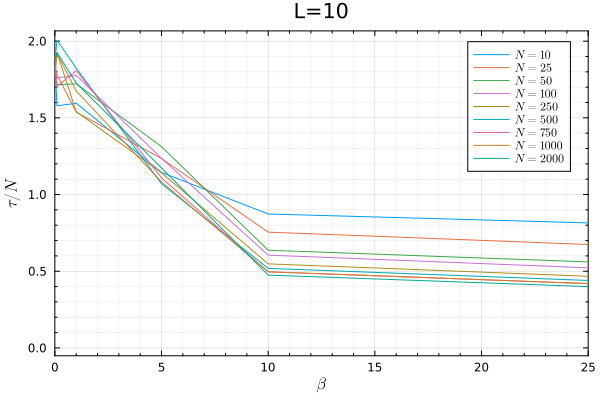

In [49]:
plot_τ_over_N(τ, N, L, β, 10^1)

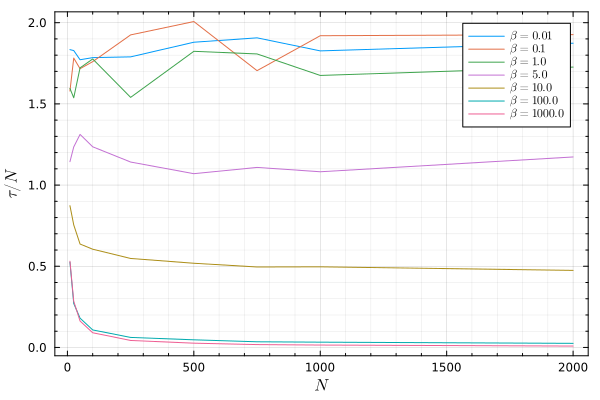

In [44]:
plot_τ_over_N2(τ, N, L, β, 10^1)


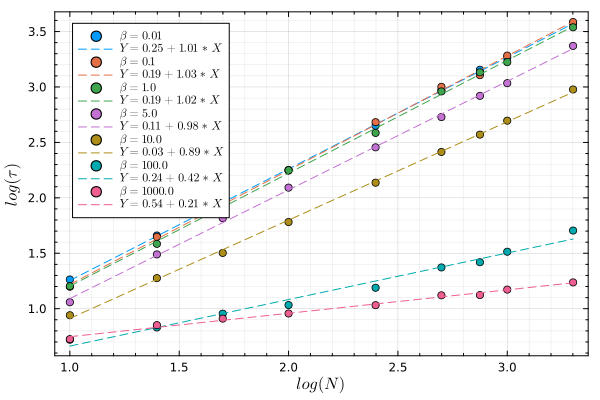

In [42]:
plot_τ_fixed_l(τ, N, L, β, 10)

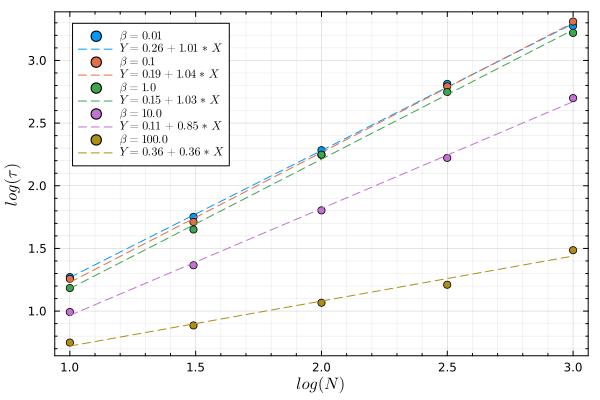

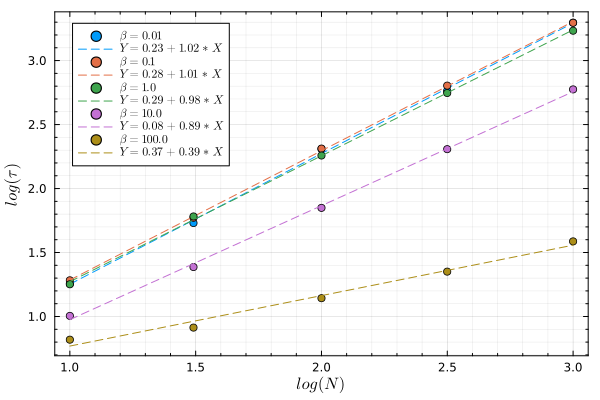

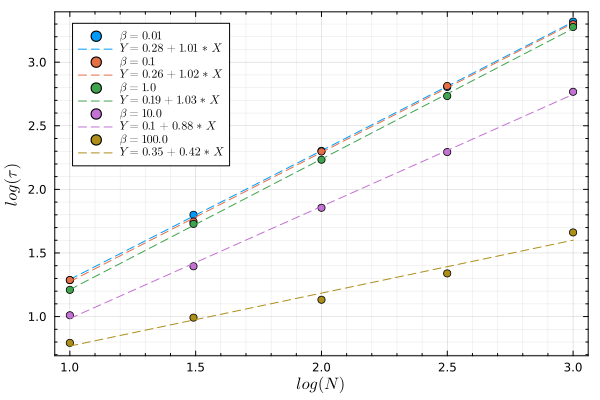

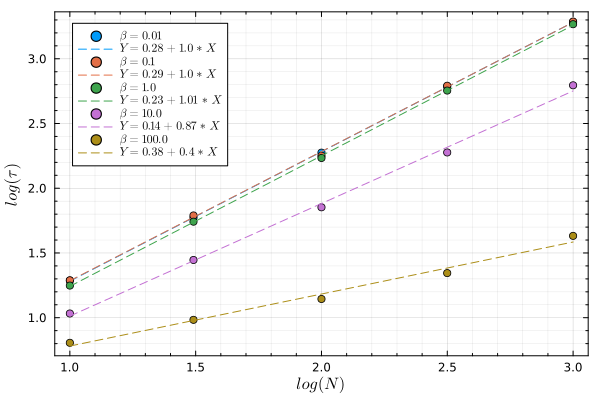

In [19]:
for l in eachindex(L)    
    plot_τ_fixed_l(τ, N, L, β, L[l])
end

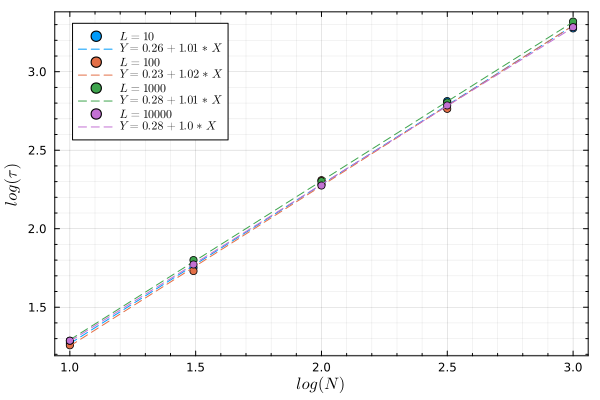

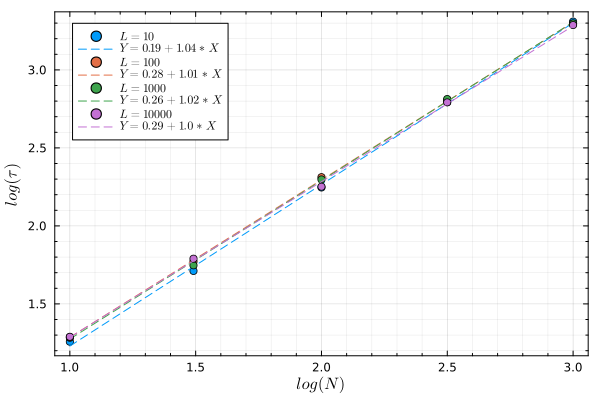

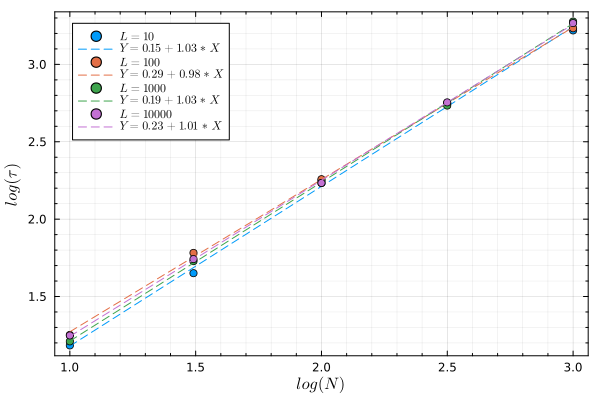

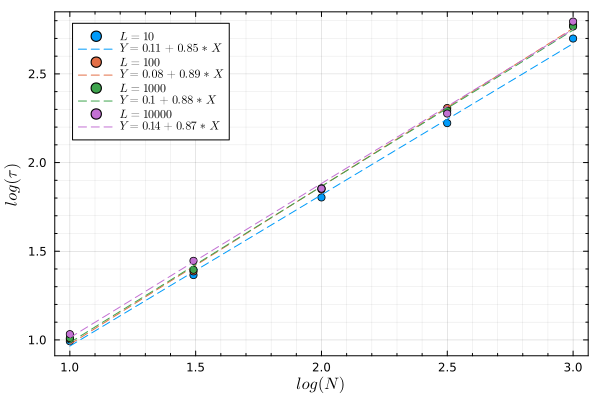

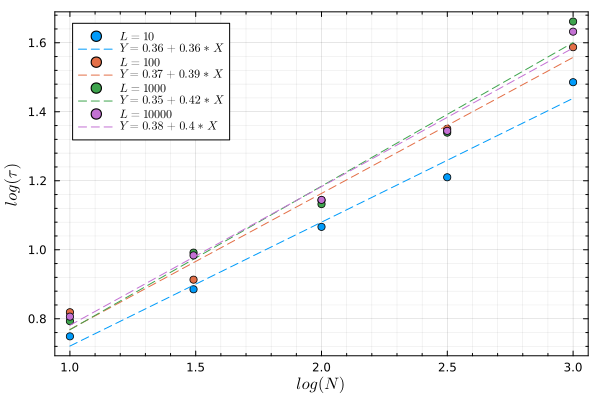

In [22]:
for b in eachindex(β)    
    plot_τ_fixed_β(τ, N, L, β, β[b])
end

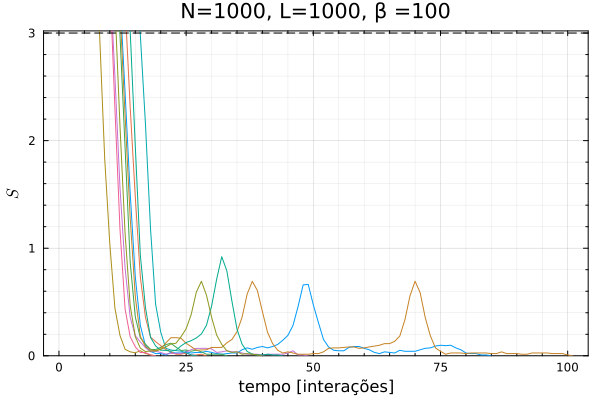

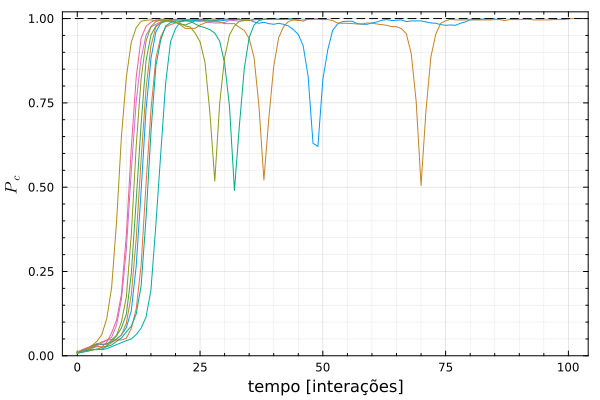

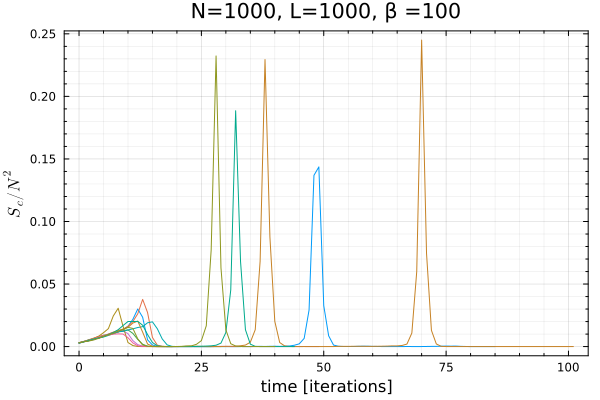

In [34]:
plot_measures(iteration, entropy, percolation, suscept, N, L, β, 10, 10^3, 10^3, 100)